In [ ]:
import requests
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

# Example of reading SIM data

Inspired from https://geosas.fr/web/?page_id=6345

In [ ]:
url_service = "https://api.geosas.fr/edr/collections/safran-isba/"
r = requests.get(url_service)
if r.ok:
    print("requete ok")
    data_info = r.json()
else:
    print("erreur code :", r.status_code)
    data_info = None

requete ok


In [ ]:
for name, parametre in data_info["parameter_names"].items():
    print(f"{name} : {parametre["description"]}")

DLI_Q : Rayonnement atmosphérique (cumul quotidien)
DRAINC_Q : Drainage (cumul quotidien 06-06 UTC)
ETP_Q : Evapotranspiration potentielle (formule de Penman-Monteith)
FF_Q : Vent (moyenne quotidienne)
HU_Q : Humidité relative (moyenne quotidienne)
PRELIQ_Q : Précipitations liquides (cumul quotidien 06-06 UTC)
PRENEI_Q : Précipitations solide (cumul quotidien 06-06 UTC)
SSI_Q : Rayonnement visible (cumul quotidien)
SWI_Q : Indice d'humidité des sols (moyenne quotidienne 06-06 UTC)
TINF_H_Q : Température minimale des 24 températures horaires
TSUP_H_Q : Température maximale des 24 températures horaires
T_Q : Température (moyenne quotidienne)


# Test avec grille LON/LAT (projection EPSG:4326)
Téléchargement des précipitations liquides et de température et de vent de l'année 2023 pour l’ensemble de la France au format NetCDF :



In [ ]:
url = "https://api.geosas.fr/edr/collections/safran-isba/cube"
param_name = "PRELIQ_Q,T_Q,FF_Q"
box = "-5.5,40.5,11.5,51.5"
projection = "EPSG:4326"
formatage = "NetCDF4"
date = "2023-01-01/2023-12-31"
params = {
    "bbox": box,
    "crs": projection,
    "parameter-name": param_name,
    "f": formatage,
    "datetime": date
}

r = requests.get(url, params=params)
if r.ok:
    print("requête ok")
    print(r.request.url)
else:
    print("erreur code :", r.status_code)

requête ok
https://api.geosas.fr/edr/collections/safran-isba/cube?bbox=-5.5%2C40.5%2C11.5%2C51.5&crs=EPSG%3A4326&parameter-name=PRELIQ_Q%2CT_Q%2CFF_Q&f=NetCDF4&datetime=2023-01-01%2F2023-12-31


In [ ]:
data=xr.open_dataset(r.content)
data

<xarray.Dataset> Size: 86MB
Dimensions:      (time: 365, y: 109, x: 180)
Coordinates:
  * time         (time) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2023-12-31
  * y            (y) float64 872B 51.11 51.02 50.93 50.84 ... 41.53 41.44 41.35
  * x            (x) float64 1kB -5.347 -5.257 -5.166 ... 10.66 10.75 10.84
Data variables:
    PRELIQ_Q     (time, y, x) float32 29MB ...
    T_Q          (time, y, x) float32 29MB ...
    FF_Q         (time, y, x) float32 29MB ...
    spatial_ref  int32 4B ...
Attributes:
    description:  Données quotidiennes du modèle de simulation des schémas de...
    id:           safran-isba
    title:        Safran-Isba, Données changement climatique - SIM quotidienne
    crs:          EPSG:4326
    rel:          https://www.etalab.gouv.fr/licence-ouverte-open-licence/

In [ ]:
!pip install cartopy
import cartopy

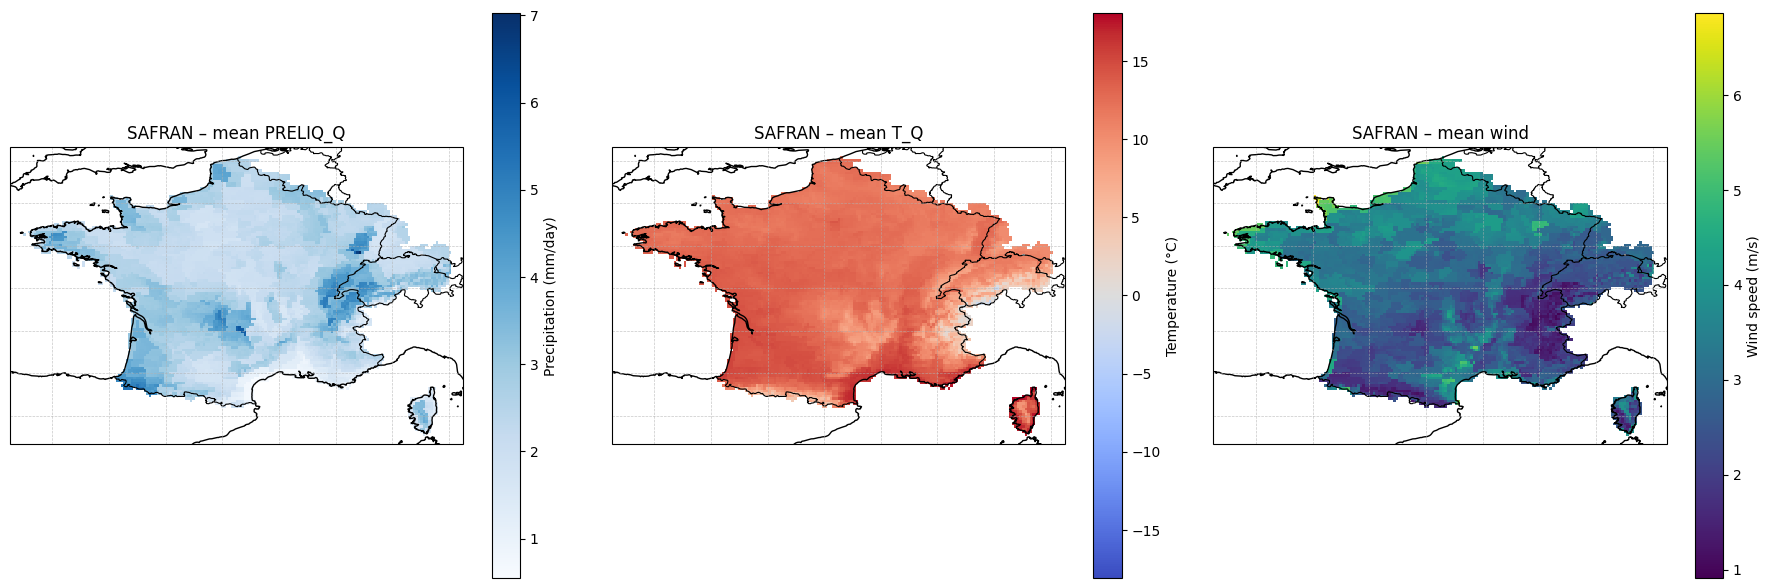

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- 1. Compute time means for each variable ---
pr_mean   = data.PRELIQ_Q.mean(dim='time')
ta_mean   = data.T_Q.mean(dim='time')
wind_mean = data.FF_Q.mean(dim='time')

data_crs = ccrs.PlateCarree()   # EPSG:4326
map_crs  = ccrs.PlateCarree()

# --- 2. Create 3 Cartopy subplots ---
fig, axes = plt.subplots(
    nrows=1, ncols=3,
    figsize=(18, 6),
    subplot_kw={"projection": map_crs}
)

def plot_field(ax, da, title, cmap, cbar_label):
    im = da.plot(
        ax=ax,
        transform=data_crs,
        cmap=cmap,
        cbar_kwargs={"label": cbar_label},
        add_colorbar=True,
    )

    ax.coastlines(resolution="10m")
    ax.add_feature(cfeature.BORDERS, linewidth=0.8)

    gl = ax.gridlines(
        draw_labels=False,   # avoid overlapping labels on all panels
        linewidth=0.5,
        linestyle="--",
        alpha=0.7
    )

    ax.set_extent([-5.5, 10.5, 41.0, 51.5], crs=data_crs)
    ax.set_title(title)
    return im

# Precip
plot_field(
    axes[0],
    pr_mean,
    "SAFRAN – mean PRELIQ_Q",
    "Blues",
    "Precipitation (mm/day)"
)

# Temperature
plot_field(
    axes[1],
    ta_mean,
    "SAFRAN – mean T_Q",
    "coolwarm",
    "Temperature (°C)"
)

# Wind
plot_field(
    axes[2],
    wind_mean,
    "SAFRAN – mean wind",
    "viridis",
    "Wind speed (m/s)"
)

plt.tight_layout()
plt.show()